In [31]:
from glob import glob
import sys, os, time

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [33]:
%matplotlib inline

In [34]:
def get_fnames(method, measure):
    return glob(os.path.join(method, measure, "*.csv"))


In [35]:
def get_df(fname):
    df = pd.read_csv(fname, header=None, names=['year', 'val'])
    df = df.dropna()
    df.year = df.year.astype(int)
    df = df.sort('year')
    return df

In [36]:
def mean_conf_interval(data, confidence=.9):
    # https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    return scipy.stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))

In [42]:
def get_overall_means(fnames, confidence=.9, num_trials=None):
    # if num_trials is none, it will use all of them
    vals = []
    if not num_trials:
        num_trials = len(fnames)
    for i in range(num_trials):
        fname = fnames[i]
        df = get_df(fname)
        vals.append(df.val)
    overall_means = np.mean(vals, axis=0)
    conf_lower, conf_upper = np.apply_along_axis(mean_conf_interval, axis=0, arr=vals, confidence=confidence)
    df_overall = pd.DataFrame({'year': df.year, 'val': overall_means, 
                        'conf_lower': conf_lower, 'conf_upper': conf_upper})
    df_overall.conf_lower = df_overall.conf_lower.fillna(df_overall.val)
    df_overall.conf_upper = df_overall.conf_upper.fillna(df_overall.val)
    return df_overall, num_trials

In [47]:
def get_plot(measure, confidence=.9, figsize=(12,8), return_dfs=False, num_trials=None):
    # measure can be "rank_mean", "size_mean", "depth_mean"
    #
    # NOTE: this plots confidence interval of means across runs, NOT within runs
    fig, ax = plt.subplots(figsize=figsize)
    methods = ['undirdir', 'outdirdir', 'pagerank', 'pagerank_unrecorded']
    colors = ['black', 'orange', 'red', 'blue']
    dfs = []
    for i in range(len(methods)):
        method = methods[i]
        fnames = get_fnames(method, measure)
        df, num_trials = get_overall_means(fnames, confidence=confidence, num_trials=num_trials)
        year_range = [1900, df.year.max()]
        ax.plot(df.year, df.val, color=colors[i], label="{} (N={})".format(method, num_trials), linewidth=1)
        ax.fill_between(df.year, df.conf_lower, df.conf_upper, color="gray", alpha=.4)
        if return_dfs:
            dfs.append(df)
    ax.set_xbound(year_range)
    ax.legend(loc='best')
    ax.set_xlabel('year')
    ax.set_ylabel(measure)
    fig.suptitle(measure)
    if return_dfs:
        return fig, ax, dfs
    return fig, ax

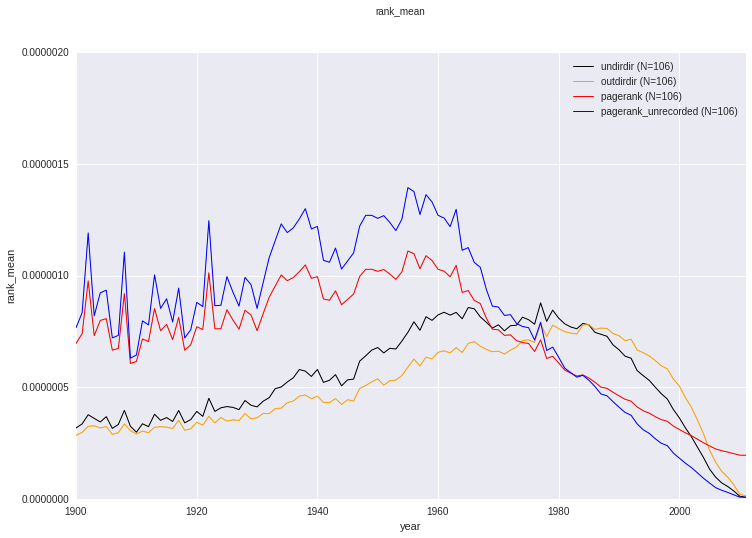

In [52]:
fig, ax = get_plot('rank_mean')
ax.set_ybound([0, 2.0e-6])
plt.show()

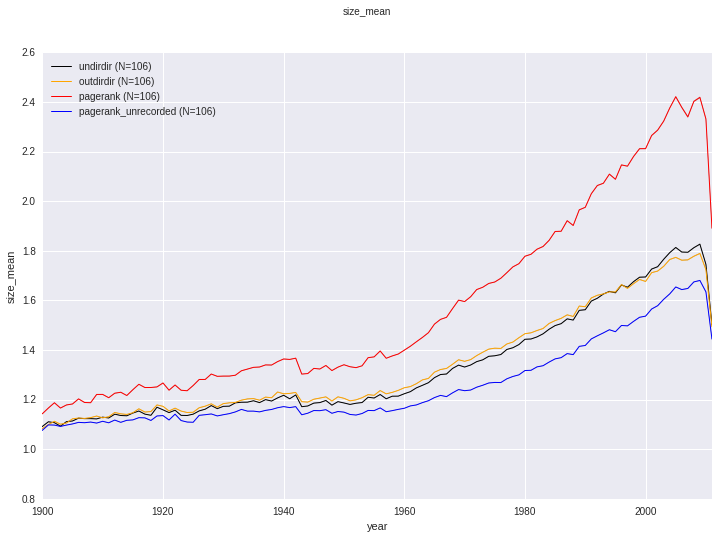

In [53]:
fig, ax = get_plot('size_mean')

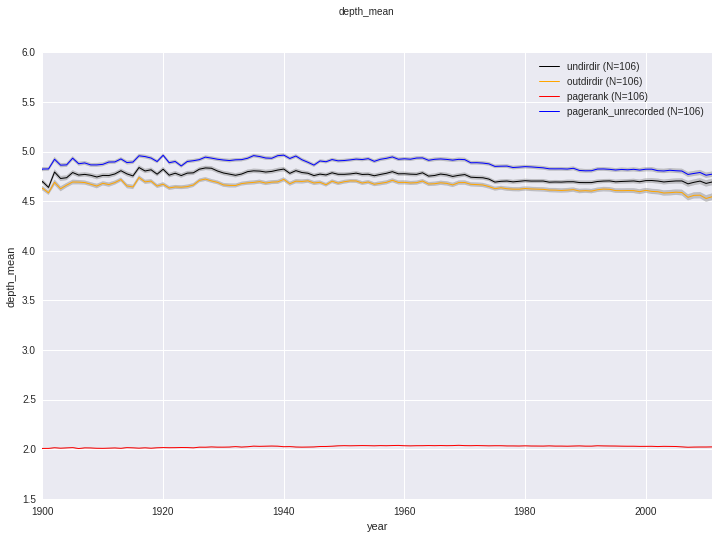

In [54]:
fig, ax = get_plot('depth_mean')